In [1]:
import pandas as pd
import os
import sys
from collections import defaultdict
from pathlib import Path
import numpy as np
import pickle
import json
import ipdb
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from tensorflow import keras

hoops_dir = Path("/Users/danielfriedman/Desktop/hoops")
data_dir = hoops_dir / "data"
lines_dir = data_dir / "lines"

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 30)


In [2]:
def american_lines_to_implied_prob(line):
    if line > 0:
        return 100/(100+line)
    else:
        return -line/(100-line)


In [3]:
eval_season = "2021-22"
sbs = pd.read_csv(data_dir / "score_by_score" / (eval_season + ".csv"))
playstats = pd.read_csv(data_dir / "playstats" / (eval_season + ".csv"))
rankings = pd.read_csv(data_dir / "rankings" / (eval_season + ".csv"))


In [4]:
model = keras.models.load_model(hoops_dir / "model/models/16_32_8|2|3|2.5e-06|home_lead_time_left_home_ranking_vis_ranking_home_lead_pml")
scaler = pickle.load(open(hoops_dir / "model/scalers/16_32_8|2|3|2.5e-06|home_lead_time_left_home_ranking_vis_ranking_home_lead_pml", "rb"))


2022-04-27 22:15:28.001333: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
sbs_reg = sbs.loc[sbs['time'] < 48].copy(deep=True) # regulation only
features = ['home_lead', 'log_time_left', 'home_ranking', 'vis_ranking', 'home_lead_per_root_minute']
sbs_reg['home_lead'] = sbs_reg['home_score'] - sbs_reg['vis_score']
sbs_reg['log_time_left'] = np.log(48 - sbs_reg['time'])
sbs_reg['ppm'] = (sbs_reg['home_score'] + sbs_reg['vis_score']) / sbs_reg['time']
sbs_reg['home_lead_per_root_minute'] = sbs_reg['home_lead'] / np.sqrt(48-sbs_reg['time'])
sbs_reg['formatted_time'] = "Q" + (1 + sbs_reg.time // 12).astype(int).astype(str) + " " + (sbs_reg.time % 12 // 1).astype(int).astype(str) + ":" + (60*(sbs_reg.time % 12 % 1)).astype(int).astype(str)


In [26]:
gameid = 22100946

## Get fitted probabilities
game_sbs = sbs_reg.loc[sbs_reg['game_id'] == gameid].reset_index(drop=True).copy(deep=True)
last_event = game_sbs.iloc[-1]
home, vis, game_date, home_score, vis_score = last_event[['home', 'vis', 'date', 'home_score', 'vis_score']]
home_ranking = rankings.loc[(rankings['date'] == game_date) & (rankings['team'] == home), 'ranking']
vis_ranking = rankings.loc[(rankings['date'] == game_date) & (rankings['team'] == vis), 'ranking']
game_sbs['home_ranking'] = home_ranking.iloc[0]
game_sbs['vis_ranking'] = vis_ranking.iloc[0]
game_features = scaler.transform(game_sbs[features].to_numpy())
home_probs = model.predict(game_features)[:,0].round(3)
# Put in terms of winner
winner = home if home_score > vis_score else vis
winner_probs = home_probs if winner == home else 1-home_probs
winner_lead = game_sbs['home_lead'] if winner == home else 1-game_sbs['home_lead']

## Get implied probabilities
date_lines_path = [path for path in os.listdir(lines_dir) if path.startswith(game_date)][0]
date_lines = pd.read_csv(lines_dir / date_lines_path).reset_index()
date_lines.sort_values(['home', 'index'], inplace=True)
date_lines.reset_index(inplace=True, drop=True)
game_lines = date_lines.loc[date_lines['home'] == home].drop(columns='index').dropna().copy(deep=True)
game_lines['time_fmt'] = game_lines['time']
game_lines['time'] = 12-game_lines['time_fmt'].str.split(":").apply(lambda time: int(time[0]) + int(time[1])/60) + 12*(game_lines.quarter.astype(int)-1)
game_lines['home_implied_prob'] = game_lines['home_mline'].apply(american_lines_to_implied_prob).round(3)
game_lines['vis_implied_prob'] = game_lines['vis_mline'].apply(american_lines_to_implied_prob).round(3)
game_lines['formatted_time'] = "Q" + (1 + game_lines.time // 12).astype(int).astype(str) + " " + (game_lines.time % 12 // 1).astype(int).astype(str) + ":" + (60*(game_lines.time % 12 % 1)).astype(int).astype(str)
# Put in terms of winner
game_lines['winner_implied_prob'] = game_lines['home_implied_prob'] if winner == home else game_lines['vis_implied_prob']
game_lines['loser_implied_prob'] = game_lines['home_implied_prob'] if winner != home else game_lines['vis_implied_prob']
game_lines['winner_lead'] = (game_lines['home_score'] - game_lines['vis_score']) * (1 if winner == home else -1)


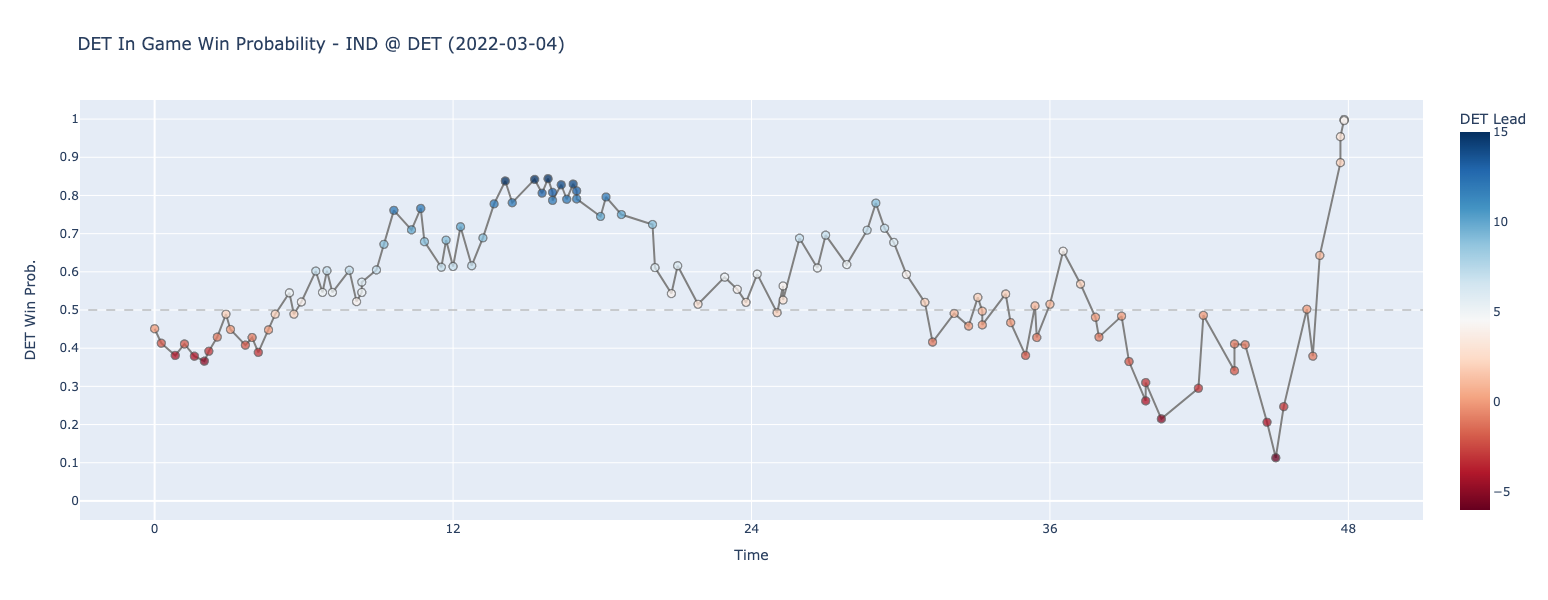

In [27]:
## Visualize
min_lead, max_lead = winner_lead.min(), winner_lead.max()
modeled_line = px.line(x=game_sbs['time'], y=winner_probs, color_discrete_sequence=["gray"])
modeled_scatter = px.scatter(game_sbs, x='time', y=winner_probs, color=winner_lead, hover_data={'formatted_time': True})
fig = go.Figure(data=modeled_line.data + modeled_scatter.data)
fig.update_coloraxes(colorbar_title=f"{winner} Lead", cmin=min_lead, cmid=0, cmax=max_lead, colorscale="RdBu")
fig.update_traces(marker={'size': 8, 'line_width': 1, 'opacity': .75})
fig.update_traces(hovertemplate='Time: %{customdata.0} <br>' + winner + ' Win Prob: %{y} <br>' + winner + ' Lead: %{marker.color}')
fig.update_xaxes(title_text="Time", range=(-3, 51))
fig.update_yaxes(title_text=f"{winner} Win Prob.", range=(-.05, 1.05))
fig.update_layout(width=1000, height=600)
fig.update_layout(title=f"{winner} In Game Win Probability - {vis} @ {home} ({game_date})",)
fig.update_layout(xaxis = {'tickmode': 'linear', 'tick0': 0, 'dtick': 12})
fig.update_layout(yaxis = {'tickmode': 'linear', 'tick0': 0, 'dtick': .1})
fig.add_shape(type='line', x0=-1000, x1=1000, y0=0.5, y1=0.5, line_color='gray', line_dash='dash', line_width=0.75)
fig.show()


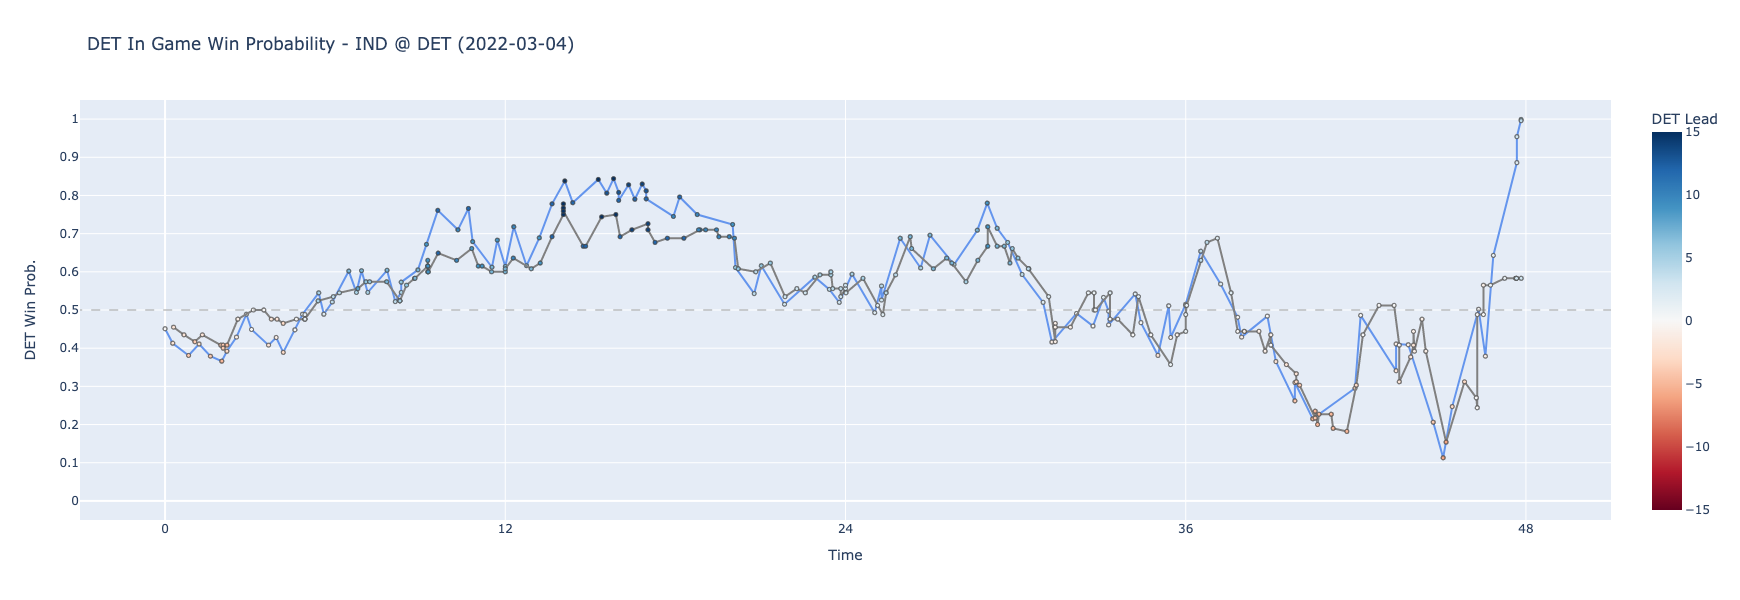

In [268]:
# Figure
fig = go.Figure()

# Model
model_line = go.Scatter(
    x=game_sbs['time'],
    y=winner_probs,
    mode='lines',
    line_color='cornflowerblue'
)
model_scatter = go.Scatter(
    x=game_sbs['time'],
    y=winner_probs,
    mode='markers',
    marker={'size': 4, 'line_width': 1, 'opacity': 1, 'color': winner_lead, 'colorscale':'RdBu', 'cmid': 0},
    customdata=np.dstack((game_sbs['formatted_time'], winner_lead))[0],
    hovertemplate='Time: %{customdata[0]} <br>' + winner + ' Modeled Win Prob: %{y} <br>' + winner + ' Lead: %{customdata[1]} <extra></extra>',
    hoverlabel={'bgcolor': 'cornflowerblue'}
)
fig.add_trace(model_line)
fig.add_trace(model_scatter)

# Implied
implied_line = go.Scatter(
    x=game_lines['time'],
    y=game_lines['winner_implied_prob'],
    mode='lines',
    line_color='gray'
)
implied_scatter = go.Scatter(
    x=game_lines['time'],
    y=game_lines['winner_implied_prob'],
    mode='markers',
    marker={'size': 4, 'line_width': 1, 'color': game_lines['winner_lead'], 'colorscale':'RdBu', 'cmid': 0, 'colorbar_title': f"{winner} Lead"},
    customdata=np.dstack((game_lines['formatted_time'], game_lines['winner_lead']))[0],
    hovertemplate='Time: %{customdata[0]} <br>' + winner + ' Implied Win Prob: %{y} <br>' + winner + ' Lead: %{customdata[1]} <extra></extra>',
    hoverlabel={'bgcolor': 'lightgray'}
)
fig.add_trace(implied_line)
fig.add_trace(implied_scatter)

# Figure
fig.update_layout(title=f"{winner} In Game Win Probability - {vis} @ {home} ({game_date})",)
fig.update_layout(xaxis = {'tickmode': 'linear', 'tick0': 0, 'dtick': 12})
fig.update_layout(yaxis = {'tickmode': 'linear', 'tick0': 0, 'dtick': .1})
fig.update_xaxes(title_text="Time", range=(-3, 51))
fig.update_yaxes(title_text=f"{winner} Win Prob.", range=(-.05, 1.05))
fig.add_shape(type='line', x0=-1000, x1=1000, y0=0.5, y1=0.5, line_color='gray', line_dash='dash', line_width=0.75)
fig.update_layout(width=1000, height=600)
fig.update_layout(showlegend=False)
fig.show()

